In [1]:
seed = 1337
valid_test_size = 0.1
maxlen = 50 # length of one training sample by words
vector_len = 100 # length of embedding vectors for each word

## Link kaggle

In [2]:
!cp '/content/drive/MyDrive/DataSets-and-Models/kaggle.json' '/content'

! mkdir ~/.kaggle

! mv kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

#! kaggle datasets list # for check

In [3]:
! kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 98% 26.0M/26.4M [00:00<00:00, 87.9MB/s]
100% 26.4M/26.4M [00:00<00:00, 77.9MB/s]


In [4]:
zip_path = '/content/entity-annotated-corpus.zip'

! unzip $zip_path
! rm $zip_path

Archive:  /content/entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


## `Problem Statement`

---

## `IMPORTS`

In [5]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from zipfile import ZipFile
from keras.layers import LSTM, Bidirectional, Input, Dense, SpatialDropout1D, Embedding, TimeDistributed
from keras.models import Model

In [6]:
np.random.seed(seed)
tf.random.set_seed(seed)

## `Load Dataset`

In [7]:
df_data = pd.read_csv('/content/ner_dataset.csv', encoding='iso-8859-1')
df_data = df_data.drop(columns='POS')
df_data.head(3)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O


In [8]:
df_data['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [9]:
df_data = df_data.fillna(method='ffill', axis=0)
df_grouped = df_data.groupby(['Sentence #'], as_index=False, sort=False).agg(lambda x: ' '.join(x))
df_grouped.head(3)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Sentence: 2,Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O B-per O O ...
2,Sentence: 3,They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo O


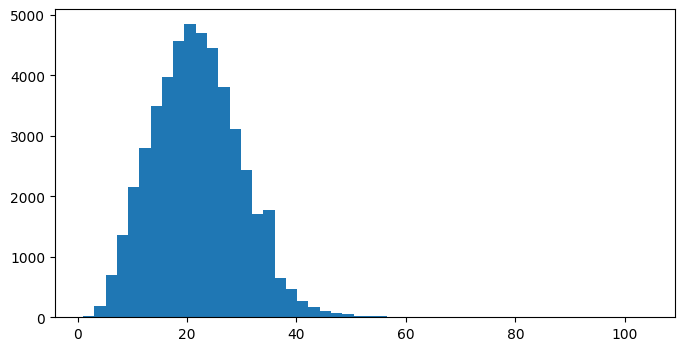

In [10]:
plt.figure(figsize=(8,4))
plt.hist([len(sentence.split(' ')) for sentence in df_grouped['Word']], bins=50);

- As we see most of sentences have length of 20 word, with almost maximum of 50 word

In [11]:
# maxlen = 50

## `STEP: DATA SPLIT`

In [12]:
x = df_grouped['Word']
y = df_grouped['Tag']

x_train, x_vt, y_train, y_vt = train_test_split(x,y, test_size=valid_test_size*2, random_state=seed)
x_valid, x_test, y_valid, y_test = train_test_split(x_vt,y_vt, test_size=0.5, random_state=seed)

print(f"Train:{x_train.shape}", f"Test:{x_test.shape}", f"Valid:{x_valid.shape}", sep=', ')

Train:(38367,), Test:(4796,), Valid:(4796,)


## `STEP: DATA PRE-PROCESSING`
- NOTE: Data is already cleaned and preprocessed, so i will do Tokenization and encoding steps

### Tokenization step

> Add blockquote



In [13]:
### Tokenization step
word2idx = Tokenizer(filters='', lower=False)
word2idx.fit_on_texts(x)

x_train_idx = word2idx.texts_to_sequences(x_train)
x_valid_idx = word2idx.texts_to_sequences(x_valid)
x_test_idx = word2idx.texts_to_sequences(x_test)

vocab_size = len(word2idx.word_index) + 1
vocab_size

35178

### Encoding step for traget

In [14]:
### Encoding step
tag2idx = Tokenizer(filters='', lower=False)
tag2idx.fit_on_texts(y)

y_train_idx = tag2idx.texts_to_sequences(y_train)
y_valid_idx = tag2idx.texts_to_sequences(y_valid)
y_test_idx = tag2idx.texts_to_sequences(y_test)

tags = len(tag2idx.word_index)
tags

17

### Padding step
- this time we will pad sentences and targets as this is many to many problem with Tx = Ty so number of tokens for input should = output tokens.
- this time i will use truncating='pre as for this problem output depend most on previous words.

In [15]:
# Padding all sentneces and tags for same maxlen.
x_train_pad = pad_sequences(x_train_idx, padding='post', truncating='pre', maxlen=maxlen)
x_valid_pad = pad_sequences(x_valid_idx, padding='post', truncating='pre', maxlen=maxlen)
x_test_pad = pad_sequences(x_test_idx, padding='post', truncating='pre', maxlen=maxlen)

y_train_pad = pad_sequences(y_train_idx, padding='post', truncating='pre', maxlen=maxlen)
y_valid_pad = pad_sequences(y_valid_idx, padding='post', truncating='pre', maxlen=maxlen)
y_test_pad = pad_sequences(y_test_idx, padding='post', truncating='pre', maxlen=maxlen)

print(f"Train_x:{x_train_pad.shape}, Train_y:{y_train_pad.shape}")

Train_x:(38367, 50), Train_y:(38367, 50)


In [16]:
## one hot encoding

y_train_ohe = keras.utils.to_categorical(y_train_pad)
y_valid_ohe = keras.utils.to_categorical(y_valid_pad)
y_test_ohe = keras.utils.to_categorical(y_test_pad)

### Form Embedding matrix step

In [17]:
### Embedding step

# download and load pre-trained embedding weights
!cp '/content/drive/MyDrive/DataSets-and-Models/glove.6B.zip' '/content/'

with ZipFile('/content/glove.6B.zip') as file:
    file.extract('glove.6B.100d.txt')

In [18]:
# form an embedding matrix form glove pre-trained embedding weights for my vocab
## BruteForce Solution with O(n=400K) where n is words of glove embeddings, better big-O solution we be in newer notebooks.

glove_embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(glove_embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, vector_len))
for word, i in word2idx.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Embedding matrix shape: " ,embedding_matrix.shape)

Loaded 400000 word vectors.
Embedding matrix shape:  (35178, 100)


## `STEP: MODELS TRAINING && Evaluation`

In [19]:
# Define Model architecture

input = Input((maxlen))
xx = Embedding(input_dim=vocab_size, output_dim=vector_len, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input)
xx = SpatialDropout1D(0.1)(xx)
xx = Bidirectional(LSTM(units=100, return_sequences=True), merge_mode='concat')(xx)
output = TimeDistributed(Dense(tags+1, activation='softmax'))(xx) ## tags+1 cuz of padding token
model = Model(input, output)
# Model compiling
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 100)           3517800   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 100)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           160800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 18)            3618      
 ributed)                                                        
                                                             

In [20]:
hist = model.fit(x=x_train_pad, y=y_train_ohe, batch_size=64, epochs=10, validation_data=(x_valid_pad, y_valid_ohe), verbose=1)


Epoch 1/10
600/600 [==============================] - 166s 268ms/step - loss: 0.1701 - accuracy: 0.9610 - val_loss: 0.0599 - val_accuracy: 0.9828
Epoch 2/10
600/600 [==============================] - 152s 253ms/step - loss: 0.0494 - accuracy: 0.9855 - val_loss: 0.0460 - val_accuracy: 0.9861
Epoch 3/10
600/600 [==============================] - 155s 259ms/step - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0429 - val_accuracy: 0.9869
Epoch 4/10
600/600 [==============================] - 158s 263ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 0.0424 - val_accuracy: 0.9870
Epoch 5/10
600/600 [==============================] - 154s 257ms/step - loss: 0.0273 - accuracy: 0.9912 - val_loss: 0.0421 - val_accuracy: 0.9873
Epoch 6/10
600/600 [==============================] - 151s 251ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.0440 - val_accuracy: 0.9870
Epoch 7/10
600/600 [==============================] - 149s 249ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0439 -

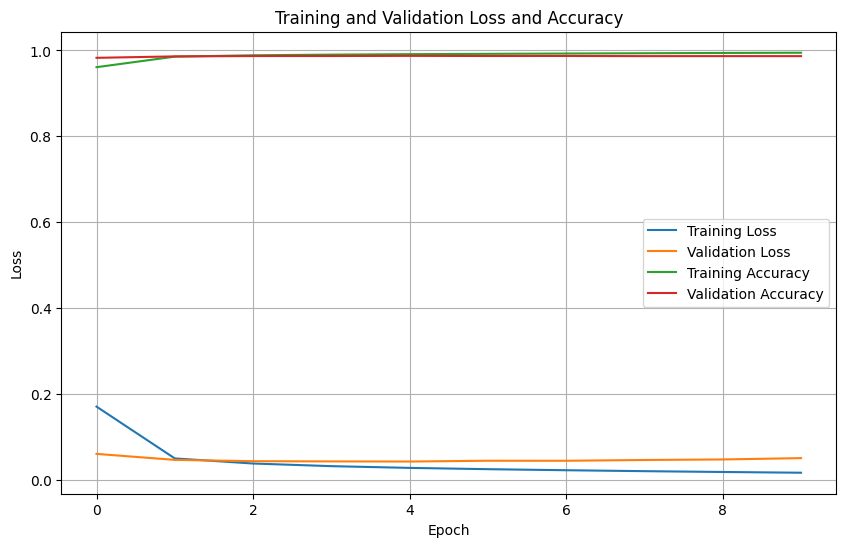

In [21]:
# Plotting the training history
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
model.evaluate(x_test_pad, y_test_ohe)

150/150 [==============================] - 4s 24ms/step - loss: 0.0517 - accuracy: 0.9863


[0.051676902920007706, 0.986259400844574]

In [23]:
## little bit overtraining but still ok.